In [1]:
%matplotlib inline
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def printmd(data):
    display(Markdown(data))

In [3]:
# loop time
LOOP_TIME = 4000 / 1e6
LOOP_TIME

0.004

In [5]:
df_calibration = pd.read_csv('./calibration.csv')
df_calibration = df_calibration[500:-500]
# df_calibration = df_calibration.drop(['tmp'], axis=1)
df_calibration = df_calibration[['gx', 'gy', 'gz']]
df_calibration

,gx,gy,gz
500,-83,76,-10
501,-85,76,-14
502,-88,75,-16
503,-88,82,-13
504,-83,77,-17
...,...,...,...
3010,-85,79,-17
3011,-79,84,-20
3012,-82,84,-19
3013,-85,74,-15


In [6]:
avg = np.average(df_calibration.values, axis=0)
avg = np.reshape(avg, (1,-1))
df_calibration = pd.DataFrame(data=avg, columns=df_calibration.columns)
df_calibration

,gx,gy,gz
0,-84.405567,78.182505,-15.367396


In [7]:
df_data_raw = pd.read_csv('./data.csv')
df_data_raw = df_data_raw.drop(['tmp'], axis=1)
df_data_raw

,gx,gy,gz,ax,ay,az
0,-85,80,-14,-335,7,3964
1,-88,72,-16,-336,12,3970
2,-85,74,-10,-332,9,3973
3,-84,80,-13,-335,-4,3970
4,-82,76,-16,-336,1,3952
...,...,...,...,...,...,...
5280,-86,39,-16,-360,1,3947
5281,-93,45,-19,-359,4,3957
5282,-82,46,-17,-359,13,3945
5283,-85,53,-16,-356,7,3929


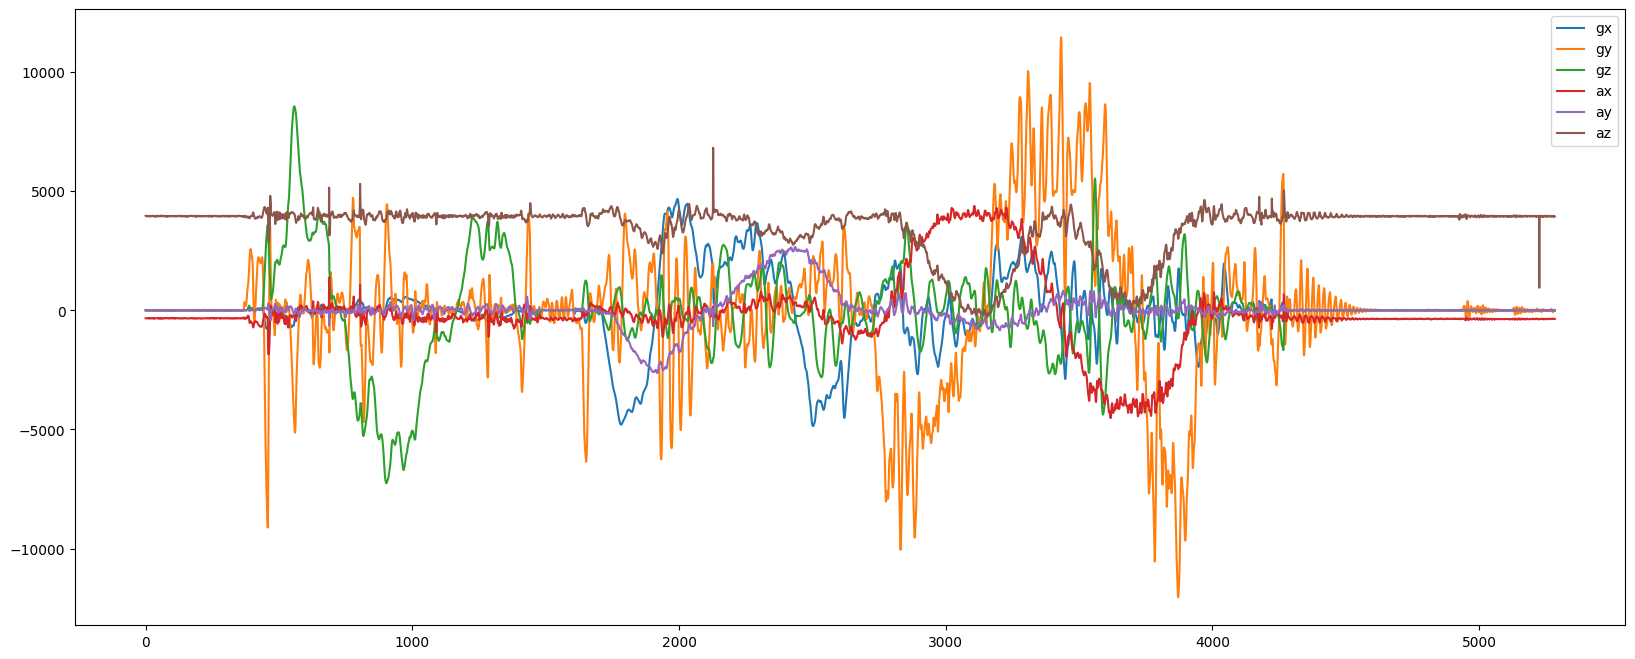

In [8]:
# calibration
data_raw = []
for i, row in df_data_raw.iterrows():
    data_raw.append([
        row['gx'] - df_calibration['gx'].values[0],
        row['gy'] - df_calibration['gy'].values[0],
        row['gz'] - df_calibration['gz'].values[0],
        row['ax'],
        row['ay'],
        row['az']
    ])

data_raw = np.array(data_raw)
df_data_raw = pd.DataFrame(data=data_raw, columns=df_data_raw.columns)

plt.figure(figsize=(20,8))
# plt.plot(df_data['a_z'])
plt.plot(df_data_raw)
plt.legend(df_data_raw.columns)
plt.show()

# Recreate control input from data

# Input commands

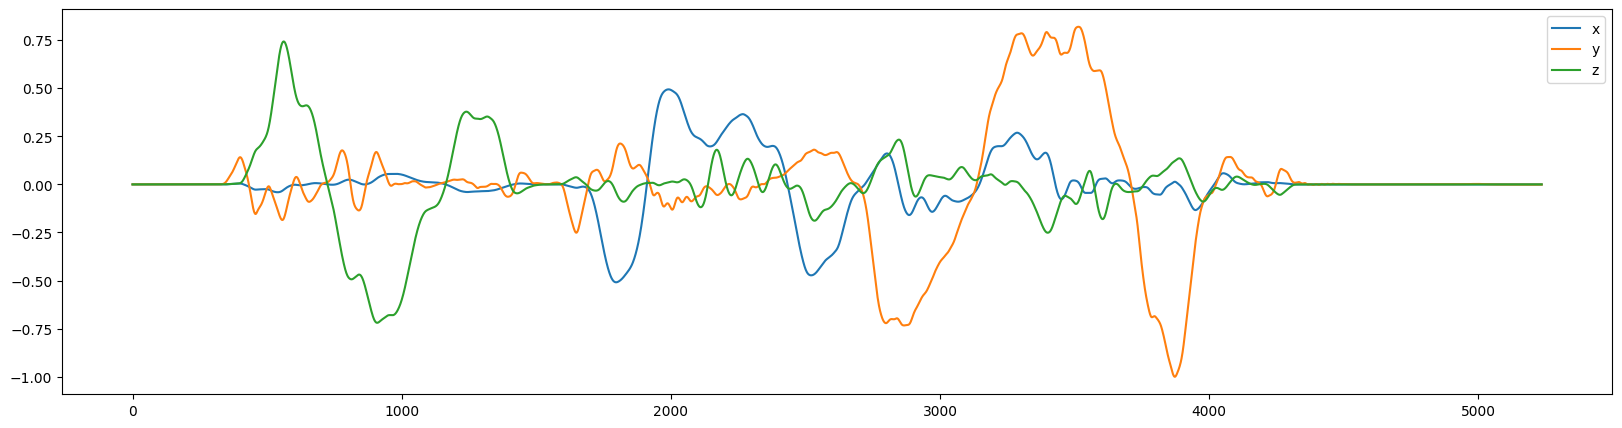

In [9]:
window_size = 50
input_commands = [
    df_data_raw['gx'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values,
    df_data_raw['gy'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values,
    df_data_raw['gz'].rolling(window=window_size).mean().rolling(window=window_size).mean()[(window_size - 1) * 1:].reset_index(drop=True).fillna(0).values
]
input_commands = np.array(input_commands)
input_commands = np.transpose(input_commands)
input_commands = pd.DataFrame(data=input_commands, columns=['x', 'y', 'z'])
# normalize data
input_commands = input_commands / np.max(np.abs(input_commands))

# make shape of data same as input
df_data_raw = df_data_raw[:input_commands.shape[0]]

printmd('# Input commands')
plt.figure(figsize=(20,5))
plt.plot(input_commands)
plt.legend(input_commands.columns)
plt.show()

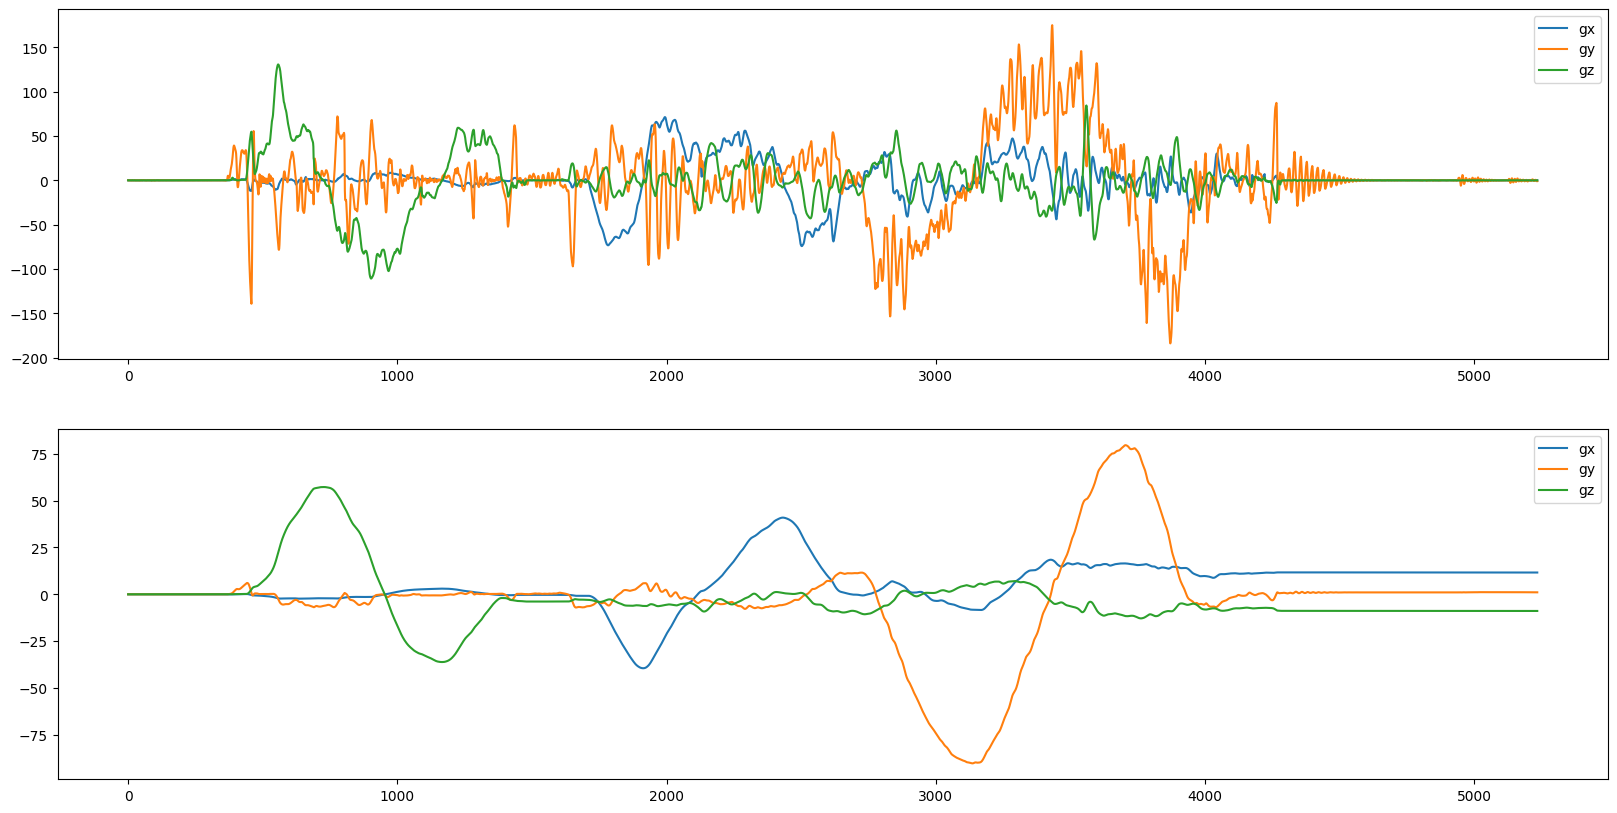

In [10]:
# angle using gyro
gyro_data_raw = df_data_raw[['gx', 'gy', 'gz']]
gyro_data_deg = gyro_data_raw / 65.5
data_rotation = np.cumsum(gyro_data_deg) * LOOP_TIME
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.plot(gyro_data_deg)
plt.legend(gyro_data_deg.columns)

plt.subplot(2, 1, 2)
plt.plot(data_rotation)
plt.legend(data_rotation.columns)

plt.show()

# Implementing the kalman filter

In [11]:
def predict(A, B, Q, u_t, mu_t, sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_sigma = A @ sigma_t @ A.T + Q
    return predicted_mu, predicted_sigma

In [12]:
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

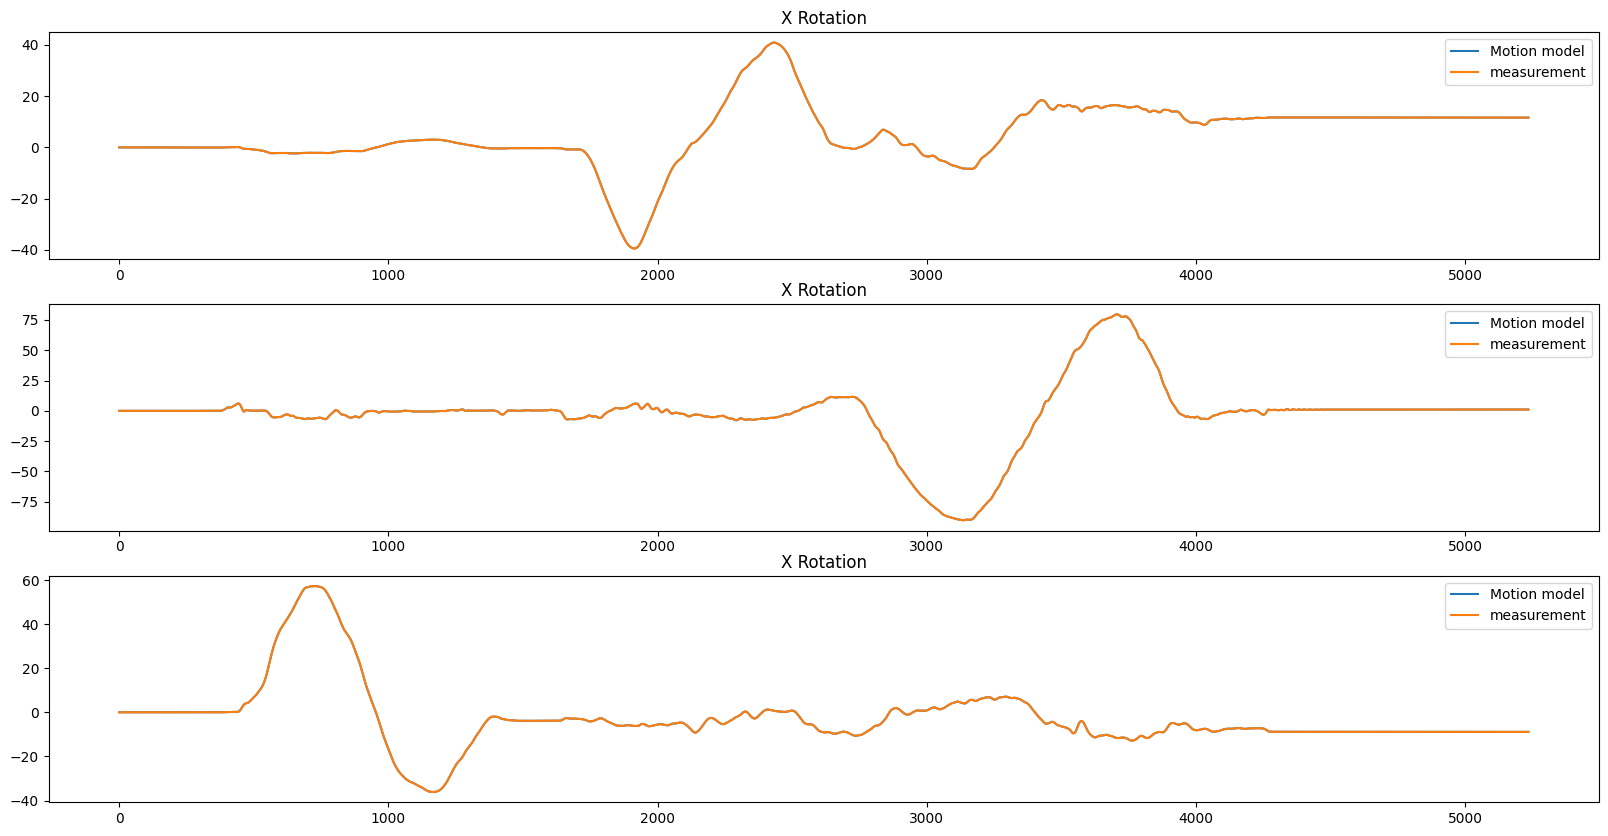

In [13]:
A = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

B = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
]) #* 0.5

Q = np.array([
    [0.1, 0, 0],
    [0, 0.1, 0],
    [0, 0, 0.1]
])

H = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

R = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 0.5]
])

mu_current = np.array([0, 0, 0])
sigma_current = np.array([
    [0.1, 0, 0],
    [0, 0.1, 0],
    [0, 0, 0.1],
])

motion_states = []
filtered_states = []

# for idx, input_command in input_commands.iterrows():
#     new_state = A @ motion_states[-1] + B @ input_command
#     motion_states.append(new_state) 

for i in range(input_commands.shape[0]):

    # print('\n\n-----------------------------------')

    # input_command = input_commands.iloc[i]
    input_command = df_data_raw.iloc[i][['gx', 'gy', 'gz']].values / 65.5 * LOOP_TIME
    
    # Predict step
    predicted_mu, predicted_sigma = predict(A, B, Q, input_command, mu_current, sigma_current)

    # measurement
    # new_measurement = data_rotation.iloc[i].values
    new_measurement = df_data_raw.iloc[i][['gx', 'gy', 'gz']].values / 65.5 * LOOP_TIME
    # new_measurement = mu_current + predicted_mu

    # update step
    # mu_current, sigma_current = update(H, R, new_measurement, predicted_mu, predicted_sigma)

    mu_current, sigma_current = predicted_mu, predicted_sigma

    motion_states.append(predicted_mu)
    filtered_states.append(mu_current)
    
    

motion_states = np.array(motion_states)
filtered_states = np.array(filtered_states) #* 0.9
rotation_state = data_rotation.values

plt.figure(figsize=(20,10))

axis = ['X', 'Y', 'Z']
legends = ['Motion model', 'measurement', 'KF']

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.title('X Rotation')
    plt.plot(motion_states[:, i])
    plt.plot(rotation_state[:, i])
    # plt.plot(filtered_states[:, i])
    plt.legend(legends)

plt.show()

In [15]:
input_command = df_data_raw.iloc[i][['gx', 'gy', 'gz']].values / 65.5 * LOOP_TIME
B, input_command

(array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 array([-3.63012763e-05, -2.55420151e-04,  3.27779886e-04]))

In [100]:
B@input_command

array([ 0.00511824, -0.00502992,  0.00126625])